In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage

import torch

In [2]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_extensions.imagenet.dataloader import get_imagenet_dls

## Load ImageNet

In [3]:
train_loader, val_loader, _ = get_imagenet_dls(root="../cgn_framework/imagenet/data/in-mini/", distributed=False, batch_size=32, workers=4)

## Get 3 samples from ImageNet

In [4]:
# Lists of best or most interesting shape/texture/background classes
# (Yes, I know all imagenet classes very well by now)
MASKS = [9, 18, 22, 35, 56, 63, 96, 97, 119, 207, 225, 260, 275, 323, 330, 350, 370, 403, 411,
         414, 427, 438, 439, 441, 460, 484, 493, 518, 532, 540, 550, 559, 561, 570, 604, 647,
         688, 713, 724, 749, 751, 756, 759, 779, 780, 802, 814, 833, 841, 849, 850, 859, 869,
         872, 873, 874, 876, 880, 881, 883, 894, 897, 898, 900, 907, 930, 933, 945, 947, 949,
         950, 953, 963, 966, 967, 980]
FOREGROUND = [12, 15, 18, 25, 54, 66, 72, 130, 145, 207, 251, 267, 271, 275, 293, 323, 385,
              388, 407, 409, 427, 438, 439, 441, 454, 461, 468, 482, 483, 486, 490, 492, 509,
              530, 555, 607, 608, 629, 649, 652, 681, 688, 719, 720, 728, 737, 741, 751, 756,
              779, 800, 810, 850, 852, 854, 869, 881, 907, 911, 930, 936, 937, 938, 941, 949,
              950, 951, 954, 957, 959, 963, 966, 985, 987, 992]
BACKGROUNDS = [7, 9, 20, 30, 35, 46, 50, 65, 72, 93, 96, 97, 119, 133, 147, 337, 350, 353, 354,
               383, 429, 460, 693, 801, 888, 947, 949, 952, 953, 955, 958, 970, 972, 973, 974,
               977, 979, 998]

def sample_classes(mode, classes=None):
    if mode == 'random':
        return np.random.randint(0, 1000, 3).tolist()

    elif mode == 'random_same':
        return [np.random.randint(0, 1000)] * 3

    elif mode == 'best_classes':
        return [np.random.choice(MASKS),
                np.random.choice(FOREGROUND),
                np.random.choice(BACKGROUNDS)]

    elif mode == 'fixed_classes':
        return [int(c) for c in classes]

    else:
        assert ValueError("Unknown sample mode {mode}")


In [5]:
shape_class, fg_class, bg_class = sample_classes('best_classes')
shape_class, fg_class, bg_class = [873, 385, 888]

In [6]:
shape_idx = np.random.choice((train_loader.dataset.labels == shape_class).nonzero()[0])
fg_idx = np.random.choice((train_loader.dataset.labels == fg_class).nonzero()[0])
bg_idx = np.random.choice((train_loader.dataset.labels == bg_class).nonzero()[0])

### Get shape from:

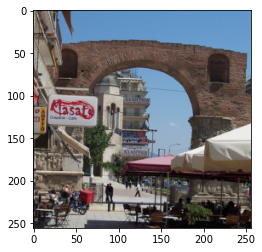

In [7]:
plt.imshow(train_loader.dataset.__getitem__(shape_idx)['ims'].transpose(0,1).transpose(1,2))

### Get foreground from:

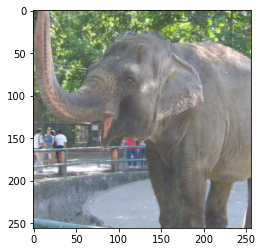

In [8]:
plt.imshow(train_loader.dataset.__getitem__(fg_idx)['ims'].transpose(0,1).transpose(1,2))

### Get background from:

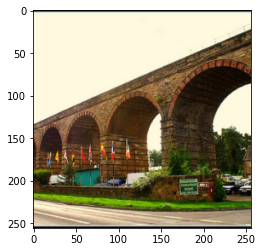

In [9]:
plt.imshow(train_loader.dataset.__getitem__(bg_idx)['ims'].transpose(0,1).transpose(1,2))

# Load U2Net

In [10]:
from  cgn_framework.imagenet.models.u2net import U2NET
us2net = U2NET.initialize('../cgn_framework/imagenet/weights/u2net.pth').eval()

## Get shape mask

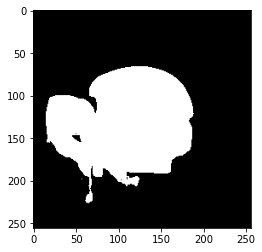

In [19]:
shape_img = train_loader.dataset.__getitem__(shape_idx)['ims'].unsqueeze(0)
shape_mask = us2net.forward(shape_img).detach().numpy().squeeze(0)
shape_mask = (shape_mask > 0.5).astype(np.uint8)
shape_img = shape_img.squeeze(0).numpy()
plt.imshow(shape_mask.transpose(1,2,0), cmap='gray')

## Get fg mask

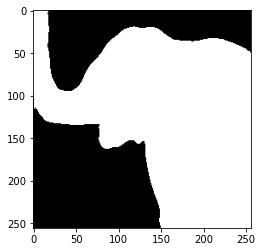

In [20]:
fg_img = train_loader.dataset.__getitem__(fg_idx)['ims'].unsqueeze(0)
fg_mask = us2net.forward(fg_img).detach().numpy().squeeze(0)
fg_mask = (fg_mask > 0.5).astype(np.uint8)
fg_img = fg_img.squeeze(0).numpy()
plt.imshow(fg_mask.transpose(1,2,0), cmap='gray')

## Get bg mask

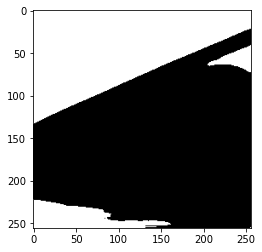

In [21]:
bg_img = train_loader.dataset.__getitem__(bg_idx)['ims'].unsqueeze(0)
bg_mask = us2net.forward(bg_img).detach().numpy().squeeze(0)
bg_mask = (bg_mask < 0.5).astype(np.uint8)
bg_img = bg_img.squeeze(0).numpy()
plt.imshow(bg_mask.transpose(1,2,0), cmap='gray')

# Create counterfactuals

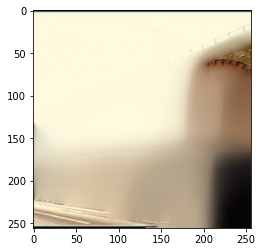

In [22]:
import cv2 as cv
bg_img_cropped = np.clip(bg_mask * bg_img, 0, 1)
bg_img_cv = (bg_img_cropped.transpose(1,2,0)*255).astype(np.uint8)
bg_img_inpainted = cv.inpaint(bg_img_cv, np.abs(bg_mask-1).transpose(1,2,0).astype(np.uint8), 50, cv.INPAINT_TELEA)/255
plt.imshow(bg_img_inpainted)

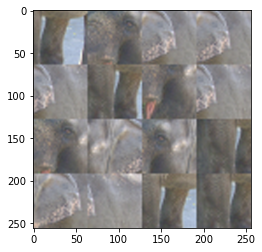

In [23]:
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch import nn
def get_all_patches(ims, patch_sz=[5, 5], pad=True):
    '''
    given a batch of images, get the surrounding patch (of patch_sz=(height,width)) for each pixel
    '''
    assert isinstance(patch_sz, list) and len(patch_sz) == 2, "Wrong format for patch_sz"

    # Pad the images - we want the patch surround each pixel
    patch_sz = np.array(patch_sz)
    patch_sz += (patch_sz+1) % 2  # round up to odd number

    # padding if we want to get the surrounding patches for *all* pixels
    if pad:
        pad = tuple((patch_sz//2).repeat(2))
        ims = nn.ReflectionPad2d(pad)(ims)

    # unfold the last 2 dimensions to get all patches
    patches = ims.unfold(2, patch_sz[0], 1).unfold(3, patch_sz[1], 1)

    # reshape to no_pixel x c x patch_sz x patch_sz
    batch_sz, c, w, h = patches.shape[:4]
    patch_batch = patches.reshape(batch_sz, c, w*h, patch_sz[0], patch_sz[1])
    patch_batch = patch_batch.permute(0, 2, 1, 3, 4)
    patch_batch = patch_batch.reshape(batch_sz*w*h, c, patch_sz[0], patch_sz[1])

    if pad: assert patch_batch.shape[0] == batch_sz * w * h  # one patch per pixel per image

    return patch_batch

def get_sampled_patches(prob_maps, paint, patch_sz=[30, 30], sample_sz=500, n_up=None):
    paint_shape = paint.shape[-2:]
    prob_maps = F.interpolate(prob_maps, (128, 128), mode='bicubic', align_corners=False)
    paint = F.interpolate(paint, (128, 128), mode='bicubic', align_corners=False)

    mode_patches = []
    if n_up is None:
        n_up = paint.shape[-1]//patch_sz[0]

    for p, prob in zip(paint, prob_maps):
        prob_patches = get_all_patches(prob.unsqueeze(0), patch_sz, pad=False)
        prob_patches_mean = prob_patches.mean((1, 2, 3))
        max_ind = torch.argsort(prob_patches_mean)[-sample_sz:]  # get 400 topvalues
        max_ind = max_ind[torch.randint(len(max_ind), (n_up**2,))].squeeze()  # sample one
        p_patches = get_all_patches(p[None], patch_sz, pad=False)
        patches = p_patches[max_ind]
        patches = make_grid(patches, nrow=n_up, padding=0)
        patches = F.interpolate(patches[None], paint_shape, mode='bicubic', align_corners=False)
        mode_patches.append(patches)

    return torch.cat(mode_patches)

texture = get_sampled_patches(torch.Tensor(fg_mask).unsqueeze(0), torch.Tensor(fg_img).unsqueeze(0))
texture = texture.squeeze(0).numpy().transpose(1,2,0)
plt.imshow(texture)

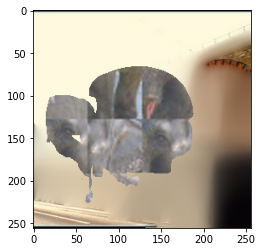

In [24]:
#mask * foreground + (1 - mask) * background
counterfactual = bg_img_inpainted * (1-shape_mask.transpose(1,2,0)) + texture * shape_mask.transpose(1,2,0)
plt.imshow(counterfactual)